# Active Learning Pipeline

In [1]:
import numpy as np 
import pandas as pd
import h5py as h5
import seaborn as sns
import tensorflow as tf
import sys

from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

import pickle
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import pytorch_lightning as pl
from tqdm.auto import tqdm

from scripts.utils import ScaleData, train_keys, target_keys

### Preparing Data

For now we will only look at a pipeline for the ITG flux. Starting with data that does give a QuaLiKiz result, run the ITG classifier and for data that is unstable use the QLKNN regressor to predict the flux.

In [3]:
train_data = pd.read_pickle("/home/tmadula/data/UKAEA/train_data_clipped.pkl")
validation_data = pd.read_pickle("/home/tmadula/data/UKAEA/valid_data_clipped.pkl")

# Keep only the data that gives an output
train_data = train_data[train_data["target"] == 1]
validation_data = validation_data[validation_data["target"] == 1]


0.26708934962202485


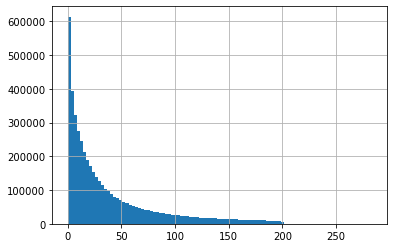

In [4]:
train_data[train_data["efiitg_gb"] != 0]["efiitg_gb"].hist(bins=100)
print(len(train_data[train_data["efiitg_gb"] != 0]) / len(train_data))

### Basic ITG Models for Prototyping

In [5]:
torch.set_default_dtype(torch.float32)

class ITG_Classifier(nn.Module):
    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            nn.Linear(15, 128),
            nn.Dropout(p=0.1),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.Dropout(p=0.1),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.Dropout(p=0.1),
            nn.ReLU(),
            nn.Linear(128, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        X = self.model(x)
        return X

class ITG_Regressor(nn.Module):
    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            nn.Linear(15, 128),
            nn.Dropout(p=0.1),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.Dropout(p=0.1),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.Dropout(p=0.1),
            nn.ReLU(),
            nn.Linear(128, 1),

        )

    def forward(self, x):
        X = self.model(x.float())
        return X

class ITGDataset(Dataset):
    def __init__(self, X, y, z = None):
        self.X = X
        self.y = y
        self.z = z

    # number of rows in the dataset
    def __len__(self):
        return len(self.y)

    # get a row at an index
    def __getitem__(self, idx):
        if self.z is not None:
            return[self.X[idx], self.y[idx], self.z[idx]]
        else:
            return [self.X[idx], self.y[idx]]

    # add method to add a new row to the dataset
    def add(self, x, y, z = None):
        self.X = np.append(self.X, x, axis = 0)
        self.y = np.append(self.y, y, axis = 0)
        
        if z is not None:
            self.z = np.append(self.z, z, axis = 0)


#### Pretrain Classifier
We will pretrain the classifier and then freeze the weights so that we only update the regressor during the active learning process.

In [6]:
keep_keys = train_keys + ["efiitg_gb"]

train_data = train_data[keep_keys]
validation_data = validation_data[keep_keys]

nt, nv = train_data.shape[0], validation_data.shape[0]
nt_nan, nv_nan =  train_data['efiitg_gb'].isna().sum(), validation_data['efiitg_gb'].isna().sum()

train_data = train_data.dropna()
validation_data = validation_data.dropna()

assert train_data.shape[0] + nt_nan == nt
assert validation_data.shape[0] + nv_nan == nv

train_data['itg'] = np.where(train_data['efiitg_gb'] != 0, 1, 0)
validation_data['itg'] = np.where(validation_data['efiitg_gb'] != 0, 1, 0)

assert len(train_data['itg'].unique()) == 2
assert len(validation_data['itg'].unique()) == 2

In [7]:
pre_train_data = train_data.sample(1_00_000)

x_train_pre = pre_train_data[train_keys].to_numpy()
y_train_class_pre = pre_train_data['itg'].to_numpy()
y_train_reg_pre =  pre_train_data['efiitg_gb'].to_numpy()

x_val = validation_data[train_keys].to_numpy()
y_val_class = validation_data['itg'].to_numpy()
y_val_reg =  validation_data['efiitg_gb'].to_numpy()

scaler = StandardScaler()

x_train_pre = scaler.fit_transform(x_train_pre)
x_val = scaler.transform(x_val)

scaler_reg = StandardScaler()

y_train_reg_pre = scaler_reg.fit_transform(y_train_reg_pre.reshape(-1,1))
y_val_reg = scaler_reg.transform(y_val_reg.reshape(-1,1))

training = ITGDataset(x_train_pre, y_train_class_pre)

train_dataloader = DataLoader(training, batch_size=1024, shuffle=True)

validation = ITGDataset(x_val, y_val_class)
validation_dataloader = DataLoader(validation, batch_size=1024, shuffle=True)


In [8]:
classifier = ITG_Classifier()

learning_rate = 1e-3

batch_size = 1024

epochs = 10

loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(classifier.parameters(), lr=learning_rate, weight_decay=1e-4)

In [9]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X.float())
        loss = loss_fn(pred, y.unsqueeze(-1).float())

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch == num_batches - 1:
            loss = loss.item()
            print(f"loss: {loss:>7f}")

def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X.float())
            test_loss += loss_fn(pred, y.unsqueeze(-1).float()).item()
            # calculate test accuracy
            pred_class = torch.round(pred.squeeze())
            correct += torch.sum(pred_class == y.float()).item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [10]:
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, classifier, loss_fn, optimizer)
    test_loop(validation_dataloader, classifier, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 0.241914
Test Error: 
 Accuracy: 90.4%, Avg loss: 0.226650 

Epoch 2
-------------------------------
loss: 0.151529
Test Error: 
 Accuracy: 92.1%, Avg loss: 0.186110 

Epoch 3
-------------------------------
loss: 0.152910
Test Error: 
 Accuracy: 92.8%, Avg loss: 0.172300 

Epoch 4
-------------------------------
loss: 0.174294
Test Error: 
 Accuracy: 93.3%, Avg loss: 0.158565 

Epoch 5
-------------------------------
loss: 0.153303
Test Error: 
 Accuracy: 93.7%, Avg loss: 0.150773 

Epoch 6
-------------------------------
loss: 0.113636
Test Error: 
 Accuracy: 93.9%, Avg loss: 0.145592 

Epoch 7
-------------------------------
loss: 0.193024
Test Error: 
 Accuracy: 94.1%, Avg loss: 0.141338 

Epoch 8
-------------------------------
loss: 0.163912
Test Error: 
 Accuracy: 94.1%, Avg loss: 0.139133 

Epoch 9
-------------------------------
loss: 0.124391
Test Error: 
 Accuracy: 94.3%, Avg loss: 0.134488 

Epoch 10
----------------------------

In [11]:
# temporarily save model
torch.save(classifier.state_dict(), "classifier_model.pt")

In [12]:
# load classifier
classifier = ITG_Classifier()
classifier.load_state_dict(torch.load("classifier_model.pt"))

<All keys matched successfully>

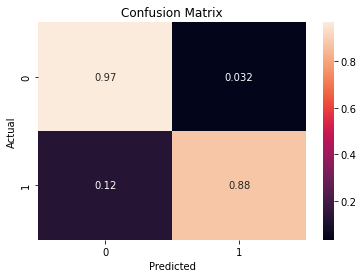

In [13]:
# get confusion matrix
y_pred = classifier(torch.tensor(x_val).float())
y_pred = torch.round(y_pred.squeeze())
y_pred = y_pred.detach().numpy()

con_mat = confusion_matrix(y_val_class, y_pred)
con_mat = con_mat / con_mat.sum(axis=1)[:, np.newaxis]

sns.heatmap(con_mat, annot=True).set(title='Confusion Matrix', xlabel='Predicted', ylabel='Actual');

### Pretrain Regressor

Now we will pretrain the regressor on a very small subset of the data and use that as our base for the active learning process.

In [14]:
reg_train = ITGDataset(x_train_pre, y_train_class_pre, y_train_reg_pre)

reg_train_dataloader = DataLoader(reg_train, batch_size=1000, shuffle=True)

reg_val = ITGDataset(x_val, y_val_class, y_val_reg)
reg_val_dataloader = DataLoader(reg_val, batch_size=1024, shuffle=False)

In [15]:
def regression_train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    for batch, (X, y, z) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X.float())
        loss = loss_fn(pred, z.float())

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch == num_batches - 1:
            loss = loss.item()
            print(f"loss: {loss:>7f}")

def regression_test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y, z in dataloader:
            pred = model(X.float())
            test_loss += loss_fn(pred, z.float()).item()

    test_loss /= num_batches
    print(f"Test Error - avg loss: {test_loss:>8f} \n")

In [16]:
regressor = ITG_Regressor()

learning_rate = 1e-3
batch_size = 1024

epochs = 25

MSE_loss = nn.MSELoss()
optimizer = torch.optim.Adam(regressor.parameters(), lr=learning_rate, weight_decay=1e-4)

In [17]:
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    regression_train_loop(reg_train_dataloader, regressor, MSE_loss, optimizer)
    regression_test_loop(reg_val_dataloader, regressor, MSE_loss)
print("Done!")

Epoch 1
-------------------------------
loss: 0.209822
Test Error - avg loss: 0.281990 

Epoch 2
-------------------------------
loss: 0.206142
Test Error - avg loss: 0.226321 

Epoch 3
-------------------------------
loss: 0.108877
Test Error - avg loss: 0.191526 

Epoch 4
-------------------------------
loss: 0.215015
Test Error - avg loss: 0.174494 

Epoch 5
-------------------------------
loss: 0.094138
Test Error - avg loss: 0.168832 

Epoch 6
-------------------------------
loss: 0.181920
Test Error - avg loss: 0.163950 

Epoch 7
-------------------------------
loss: 0.125628
Test Error - avg loss: 0.158444 

Epoch 8
-------------------------------
loss: 0.167200
Test Error - avg loss: 0.149530 

Epoch 9
-------------------------------
loss: 0.133741
Test Error - avg loss: 0.143989 

Epoch 10
-------------------------------
loss: 0.141821
Test Error - avg loss: 0.145548 

Epoch 11
-------------------------------
loss: 0.118304
Test Error - avg loss: 0.139283 

Epoch 12
----------

In [18]:
# temporarily save model
torch.save(regressor.state_dict(), "regression_model.pt")

In [19]:
# load regression model
regressor = ITG_Regressor()
regressor.load_state_dict(torch.load("regression_model.pt"))

<All keys matched successfully>

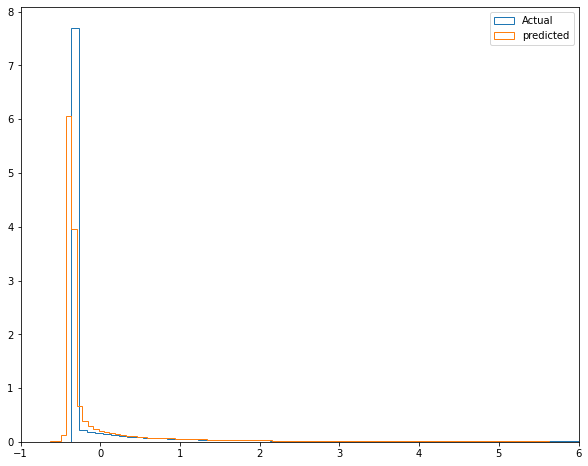

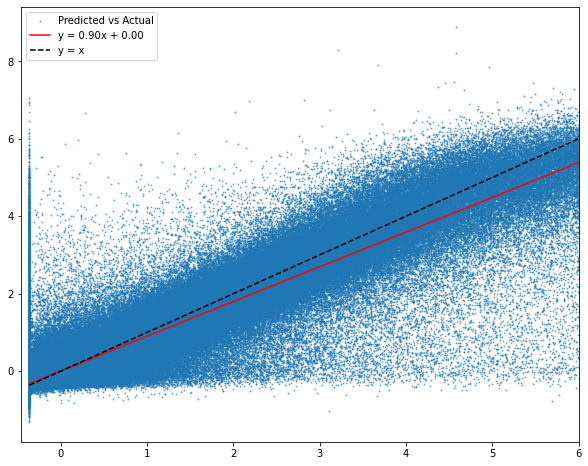

In [20]:
# plot histogram of predicted values
y_pred = regressor(torch.tensor(x_val).float()).detach().numpy()

plt.figure(figsize=(10,8))
plt.hist(y_val_reg, bins=100, density = True, histtype = 'step', label="Actual");

plt.hist(y_pred, bins=150, density=True, histtype='step', label='predicted');

plt.legend();
plt.xlim(-1,6)

# plot scatter plot of predicted vs actual
plt.figure(figsize = (10,8))
plt.scatter(y_val_reg, y_pred, s=1, alpha=0.5, label = "Predicted vs Actual");

min_x = np.min(y_val_reg)

# get line of best fit
m, b = np.polyfit(y_val_reg.squeeze(), y_pred, 1)
plt.plot(np.linspace(min_x,6,100), m*np.linspace(min_x,6,100)+b, 'r-', label=f'y = {m[0]:.2f}x + {b[0]:.2f}');

plt.plot([min_x,6],[min_x,6], 'k--', label = 'y = x');
plt.xlim(min_x - 0.1,6)
plt.legend();



#### Active Learning

First pass, will put everything into nice functions after

In [21]:
x_train = train_data[train_keys].to_numpy()
y_train_class = train_data['itg'].to_numpy()
y_train_reg =  train_data['efiitg_gb'].to_numpy()

x_train = scaler.transform(x_train)
y_train_reg = scaler_reg.transform(y_train_reg.reshape(-1, 1))

# What is happening here???
#x_train = x_train_pre
#y_train_class = y_train_class_pre
#y_train_reg = y_train_reg_pre

# Start with only a small subset of the data
indices = np.random.choice(len(x_train), size=10_000, replace=False)

training_reg = ITGDataset(x_train[indices], y_train_class[indices], y_train_reg[indices])
train_dataloader_reg = DataLoader(training_reg, batch_size=10_000, shuffle=False)

# Actual number of unstable points
print(len(y_train_class[indices][y_train_class[indices] == 1]))

2671


2364


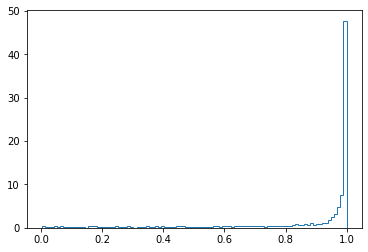

In [22]:
plt.figure()

out = classifier(torch.from_numpy(training_reg.X[training_reg.y == 1]).float())

plt.hist(out.detach().numpy(), bins=100, density=True, histtype='step', label='predicted');

rounded = np.round(out.detach().numpy()).astype(int)
print(len(rounded[rounded == 1]))

In [23]:
classifier.eval()

for X, y, z in train_dataloader_reg:
    pred = classifier(X.float())
    pred_class = torch.round(pred.squeeze()).detach().numpy()
    pred_class = pred_class.astype(int)


    #print number of points incorrectly classified
    print(len(pred_class[pred_class != y.numpy()]))

    # add data that returns one to a new dataset
    training_reg_pass = ITGDataset(X[pred_class == 1], y[pred_class == 1], z[pred_class == 1])

print(f"Number of points passing classifier: {len(training_reg_pass)}")

training_reg_pass_dataloader = DataLoader(training_reg_pass, shuffle=False)

# number of incorrect points passing classifier
len(training_reg_pass.y[training_reg_pass.y == 0])

498
Number of points passing classifier: 2611


219

In [24]:
def enable_dropout(model):
    """Function to enable the dropout layers during test-time"""
    for m in model.modules():
        if m.__class__.__name__.startswith("Dropout"):
            m.train()

  0%|          | 0/100 [00:00<?, ?it/s]

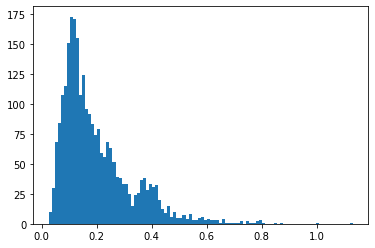

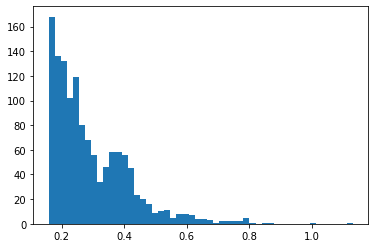

In [25]:
regressor.eval()
enable_dropout(regressor)

# evaluate model on training data 100 times and return points with largest uncertainty
runs = []
for i in tqdm(range(100)):
    step_list = []
    for step, (x, y, z) in enumerate(training_reg_pass_dataloader):

        predictions = regressor(x.float()).detach().numpy()
        step_list.append(predictions)

    flattened_predictions = np.array(step_list).flatten()
    runs.append(flattened_predictions)

out_std = np.std(np.array(runs), axis=0)

plt.figure()
plt.hist(out_std, bins=100)

# get indices of top 10% of points
top_indices = np.argsort(out_std)[-int(len(out_std) * 0.5):]
plt.figure()
plt.hist(out_std[top_indices], bins=50);

### Maybe train using some of the original training dataset and high variance points for balance? 

In [26]:
# load regression model
regressor = ITG_Regressor()
regressor.load_state_dict(torch.load("regression_model.pt"))

<All keys matched successfully>

In [27]:
# Put most uncertain points in a dataset
training_reg_pass_dataloader2 = DataLoader(training_reg_pass, batch_size = len(training_reg_pass), shuffle=False)
for step, (x, y, z) in enumerate(training_reg_pass_dataloader2):
    uncertain_data = ITGDataset(x[top_indices], y[top_indices], z[top_indices].reshape(-1,1))

tune_dataloader = DataLoader(uncertain_data, shuffle=False)

print(len(uncertain_data.y[uncertain_data.y == 1]))
print(len(uncertain_data.y[uncertain_data.y == 0]))

1223
82


In [28]:
regressor.train()

optimizer = torch.optim.Adam(regressor.parameters(), lr = 1e-4, weight_decay=1e-4)


print(f"Validation MSE loss before fine tuning using high variance points:")
regression_test_loop(reg_val_dataloader, regressor, MSE_loss)

epochs = 5

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")

    # Add in some of the training data to balance the fine tuning on the most uncertain points

    #train_idx = np.random.choice(len(x_train_pre), size=len(top_indices), replace=False)
    #tune_dataset.add(x_train_pre[train_idx], y_train_class_pre[train_idx], y_train_reg_pre[train_idx])

    if t % 2 == 0:
        regression_train_loop(reg_train_dataloader, regressor, MSE_loss, optimizer)

    regression_train_loop(tune_dataloader, regressor, MSE_loss, optimizer)
    
    regression_test_loop(reg_val_dataloader, regressor, MSE_loss)
print("Done!")


Validation MSE loss before fine tuning using high variance points:
Test Error - avg loss: 0.120353 

Epoch 1
-------------------------------
loss: 0.059742
loss: 5.726789
Test Error - avg loss: 0.162713 

Epoch 2
-------------------------------
loss: 5.607873
Test Error - avg loss: 0.157887 

Epoch 3
-------------------------------
loss: 0.192604
loss: 2.665610
Test Error - avg loss: 0.143201 

Epoch 4
-------------------------------
loss: 1.826878
Test Error - avg loss: 0.149349 

Epoch 5
-------------------------------
loss: 0.085817
loss: 9.204684
Test Error - avg loss: 0.152981 

Done!


In [29]:
# Recalculate uncertainty to see if it has reduced
runs_after = []
for i in tqdm(range(100)):
    step_list = []
    for step, (x, y, z) in enumerate(tune_dataloader):

        predictions = regressor(x.float()).detach().numpy()
        step_list.append(predictions)

    flattened_predictions = np.array(step_list).flatten()
    runs_after.append(flattened_predictions)

out_std_after = np.std(np.array(runs_after), axis=0)

  0%|          | 0/100 [00:00<?, ?it/s]

(0.0, 1.0)

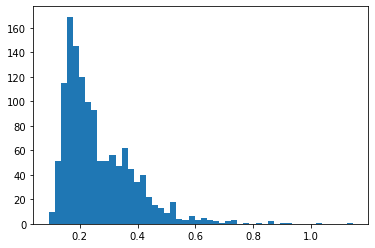

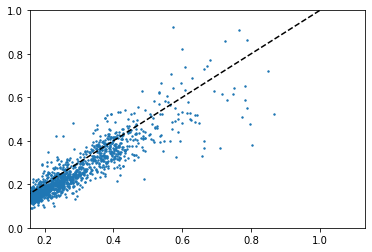

In [30]:
plt.figure()
plt.hist(out_std_after, bins=50);

plt.figure()
plt.scatter(out_std[top_indices], out_std_after, s=2, alpha=1);

plt.plot([0.0,2.5],[0,2.5], 'k--', label = 'y = x');
plt.xlim(out_std[top_indices].min(), out_std[top_indices].max());
plt.ylim(0,1)

In [40]:
def uncertainty_change(x,y): 
    theta = np.arctan(y,x)
    theta = np.rad2deg(theta)

    total = theta.shape[0]

    decrease = len(theta[theta < 45])*100/total
    increase = len(theta[theta > 45])*100/total
    no_chnage = 100 - increase - decrease

    print(f' Decreased {decrease:.3f}% Increased: {increase:.3f} % No Change: {no_chnage:.3f} ')

In [41]:
uncertainty_change(out_std[top_indices], out_std_after )

 Decreased 99.847% Increased: 0.153 % No Change: 0.000 


  0%|          | 0/100 [00:00<?, ?it/s]

(0.02441147342324257, 1.1311798095703125)

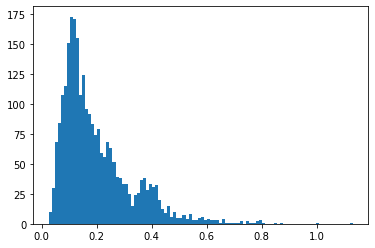

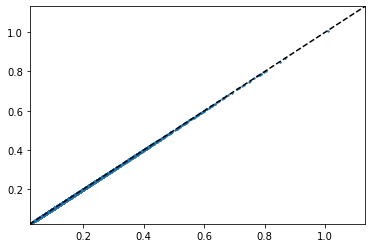

In [31]:
# Repeat uncertainty calculation on full dataset to see if it has increased

runs_full = []
for i in tqdm(range(100)):
    step_list = []
    for step, (x, y, z) in enumerate(training_reg_pass_dataloader):

        predictions = regressor(x.float()).detach().numpy()
        step_list.append(predictions)

    flattened_predictions = np.array(step_list).flatten()
    runs_full.append(flattened_predictions)

out_std_full = np.std(np.array(runs), axis=0)

plt.figure()
plt.hist(out_std_full, bins=100)

plt.figure()
plt.scatter(out_std, out_std_full, s=2, alpha=1);
plt.plot([0.0,2],[0,2], 'k--', label = 'y = x');
plt.xlim(out_std.min(), out_std.max())
plt.ylim(out_std_full.min(), out_std_full.max())

In [ ]:
uncertainty_change(out_std,out_std_full)

### Now Turn into a Pipeline with Functions

In [ ]:
def select_random_points(X, y, z, n_points):
    """
    Selects n_points random points from the dataset.
    """
    indices = np.random.choice(len(X), n_points, replace=False)

    dataset = ITGDataset(X[indices], y[indices], z[indices])
    dataloader = DataLoader(training_reg, batch_size=n_points, shuffle=True)

    return dataset, dataloader

def unstable_itg_points(dataloader, classifier):
    """
    Returns a dataset of points that are unstable.
    """
    classifier.eval()
    unstable_points = []
    for step, (x, y, z) in enumerate(dataloader):
        pred = classifier(x.float())
        pred_class = torch.round(pred.squeeze()).detach().numpy()
        pred_class = pred_class.astype(int)
        # add data that returns one to a new dataset
        unstable_points.append(pred_class == 1)

        if step == 0:
            unstable_dataset = ITGDataset(x[pred_class == 1], y[pred_class == 1], z[pred_class == 1])
        else:
            unstable_dataset.add(x[pred_class == 1], y[pred_class == 1], z[pred_class == 1])
    

    print(f"Number of unstable points: {len(unstable_dataset)}")
    unstable_dataloader = DataLoader(unstable_dataset, shuffle=True)
    return unstable_dataloader

dataset, dataloader = select_random_points(x_train, y_train_class, y_train_reg, n_points=10_000)
zz = unstable_itg_points(dataloader, classifier)

for X, y, z in dataloader:
    pred = classifier(X.float())
    pred_class = torch.round(pred.squeeze()).detach().numpy()
    pred_class = pred_class.astype(int)
    # add data that returns one to a new dataset
    dataloader_pass = ITGDataset(X[pred_class == 1], y[pred_class == 1], z[pred_class == 1])

print(f"Number of points passing classifier: {len(dataloader_pass)}")

# check two arrays are the same (even if not in the same order)
assert np.array_equal(np.sort(torch.flatten(zz.dataset.X)), np.sort(torch.flatten(dataloader_pass.X)))

In [ ]:
def regressor_uncertainty(dataloader, regressor, keep = 0.1):
    """
    Calculates the uncertainty of the regressor on the points in the dataloader.
    Returns the most uncertain points.

    """

    regressor.eval()
    enable_dropout(regressor)

    # evaluate model on training data 100 times and return points with largest uncertainty
    runs = []
    for i in tqdm(range(100)):
        step_list = []
        for step, (x, y, z) in enumerate(dataloader):

            predictions = regressor(x.float()).detach().numpy()
            step_list.append(predictions)

        flattened_predictions = np.array(step_list).flatten()
        runs.append(flattened_predictions)

    out_std = np.std(np.array(runs), axis=0)

    top_indices = np.argsort(out_std)[-int(len(out_std) * keep):]

    uncertain_dataset = ITGDataset(
        dataloader.dataset.X[top_indices],
        dataloader.dataset.y[top_indices], 
        dataloader.dataset.z[top_indices].reshape(-1, 1)
        )

    uncertain_dataloader = DataLoader(uncertain_dataset, shuffle=True)

    return uncertain_dataloader